## Yield Spread model
This notebook implements a model to predict new yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers. The model is trained on data from 1 May 2022 to 31 December 2022. The test set is the month of January 2023. 

Last Update: Changed the label to yield spreads calculated using new ficc ycl

The notebook contains a table with the results of all experiments. FICC treasury spreads is the spread calculated by taking the difference of the FICC ycl and the treasury yield for the same maturity. We also experiment with feeding the treasury rates for all maturities. Another feature is the difference in the treasury rate for the target trade and the treasury rate a day before. We also experiment with the Ted rate, which is the difference between the 10-year treasury rate and 2-year treasury rate. A positive ted rate shows a positive outlook for the economy and vice-versa for a negative ted rate.

I have added an additional table that includes the results for different exclusions. 

Note: Change NUM_FEATURES to 6 if you want to train with treasury spreads

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay



from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


In [2]:
tf.__version__

'2.7.0'

Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [4]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [5]:
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [7]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
# with fs.open('ficc_training_data_latest/processed_data_2023-02-10-02-58.pkl') as f:
with fs.open('ahmad_data/processed_data.pkl') as f:
# with fs.open('ficc_training_data_latest/processed_data_2023-03-03-16:43.pkl') as f:
# with fs.open('automated_training/processed_data.pkl') as f:
    data = pd.read_pickle(f)

In [8]:
# import gcsfs
# fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
# # with fs.open('ficc_training_data_latest/processed_data_2023-02-10-02-58.pkl') as f:
# with fs.open('ahmad_data/today_data.pkl') as f:
# # with fs.open('ficc_training_data_latest/processed_data_2023-03-03-16:43.pkl') as f:
# # with fs.open('automated_training/processed_data.pkl') as f:
#     t_data = pd.read_pickle(f)

Date range of data

In [44]:
# data = pd.concat([t_data, data])

In [45]:
# data.trade_date.max()

In [46]:
# data.trade_date.min()

In [9]:
np.unique(data[data.rating == 'CC']['cusip'])

array(['914811NR1', '914811NS9', '914811NT7', '914811NU4', '914811PM0',
       '914811PN8', '914811PQ1', '914811PR9', '914811PX6', '914811QA5'],
      dtype=object)

#### Adding features from Charles's notebook

In [13]:
%%time
data['ttypes'] = (data.last_trade_type.astype(str) + data.trade_type.astype(str)).astype('category')
data['diff_size'] = (data.par_traded.astype(float) - data.last_size).astype(np.float32)
data['abs_last_yield_spread'] = np.abs(data['last_yield_spread'])
data['abs_diff_size'] = np.abs(data['diff_size'])
data['days_duration'] = (data.last_calc_date - data.last_settlement_date).dt.days

CPU times: user 3.62 s, sys: 147 ms, total: 3.77 s
Wall time: 3.76 s


In [7]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']

This feature is used to check if there are any NaN values in the trade history. **It is not used to train the model**. 

In [17]:
%%time
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))

CPU times: user 37.3 s, sys: 12.8 s, total: 50.1 s
Wall time: 55.2 s


Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions. These exclusions were discussed with a team member. 
<ul>
    <li>Callable less than a year in the future </li>
    <li>Maturity less than a year in the future and more than 30 years in the future</li>
<ul>

In [35]:
data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
data = data[data.days_to_maturity < np.log10(30000)]

In [18]:
len(data)

8811265

For the purpose of plotting, not used in training

In [19]:
data.purpose_sub_class.fillna(0, inplace=True)

Adding the concatenated trade type, target trade attention, and treasury spread over ficc ycl in PREDICTORS to train the model.

In [20]:
data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100

In [21]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

In [22]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.

In [23]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     #'same_ys',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                      'last_dollar_price',
                      'last_rtrs_control_number',
                     'is_called']

In [24]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]# + ['target_attention_features','yield_spread']]

In [25]:
len(processed_data)

8811265

Used to drop NaN values in trade history.

In [26]:
processed_data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])

In [27]:
len(processed_data)

8811265

In [28]:
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)

In [29]:
processed_data.dropna(inplace=True, subset=PREDICTORS)

In [30]:
len(processed_data)

8811265

Creating yield spreads from new ficc ycl

In [31]:
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [8]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    fprep = preprocessing.LabelEncoder().fit(data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class


#### Splitting the data into train and test sets



In [33]:
train_dataframe = processed_data[processed_data.trade_date < '04-01-2023']

In [34]:
test_dataframe = processed_data[(processed_data.trade_date >= '03-01-2023') & (processed_data.trade_date <= '03-31-2023') ]

In [35]:
len(train_dataframe)

8260279

In [36]:
len(test_dataframe)

433193

Converting data into format suitable for the model

In [37]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [38]:
%%time
x_train = create_input(train_dataframe)
# y_train = train_dataframe.yield_spread
y_train = train_dataframe.new_ys
# y_train = train_dataframe.same_ys

CPU times: user 27.5 s, sys: 1.1 s, total: 28.6 s
Wall time: 28.6 s


In [39]:
%%time
x_test = create_input(test_dataframe)
# y_test = test_dataframe.yield_spread
y_test = test_dataframe.new_ys
# y_test = test_dataframe.same_ys

CPU times: user 1.84 s, sys: 0 ns, total: 1.84 s
Wall time: 1.84 s


In [40]:
x_train[0].shape

(8260279, 5, 6)

In [41]:
x_test[2].shape

(433193, 27)

## LightGBM

In [42]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY ] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features','yield_spread'])
    return df

In [43]:
trainlabel = train_dataframe.new_ys
testlabel = test_dataframe.new_ys

In [44]:
gbt_td = gbmprep(train_dataframe[PREDICTORS ])

In [45]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [46]:
%%time
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 28min 54s, sys: 2.67 s, total: 28min 57s
Wall time: 1min 6s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [47]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe[PREDICTORS] ) )
delta = testlabel - gbt_pred
print( delta.mean(), delta.abs().mean() )

-1.7417500922293465 11.23986912805938
CPU times: user 46.8 s, sys: 119 ms, total: 46.9 s
Wall time: 2.02 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

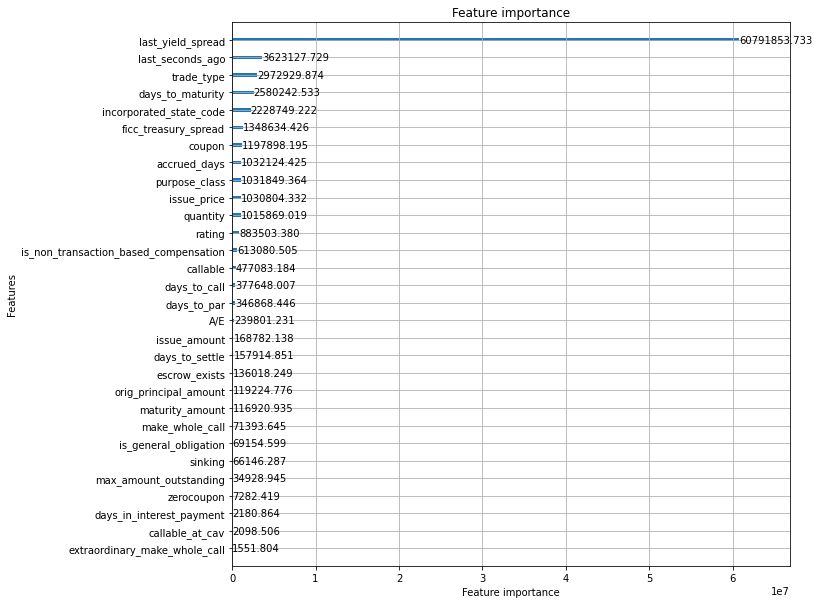

In [48]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10), importance_type='gain')

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [49]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

In [50]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

#### Setting the seed for intialization of the layers

In [51]:
tf.keras.utils.set_random_seed(10)

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [52]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth, name='weights_query') 
        self.wk = layers.Dense(depth, name='weights_key')
        self.wv = layers.Dense(depth, name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [53]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(SEQUENCE_LENGTH, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM')

lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           return_sequences = False,
                           name='LSTM_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
features = lstm_attention_layer(features, features, inputs[1])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu')(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                    input_length= 1,
                                                                    name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh')(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

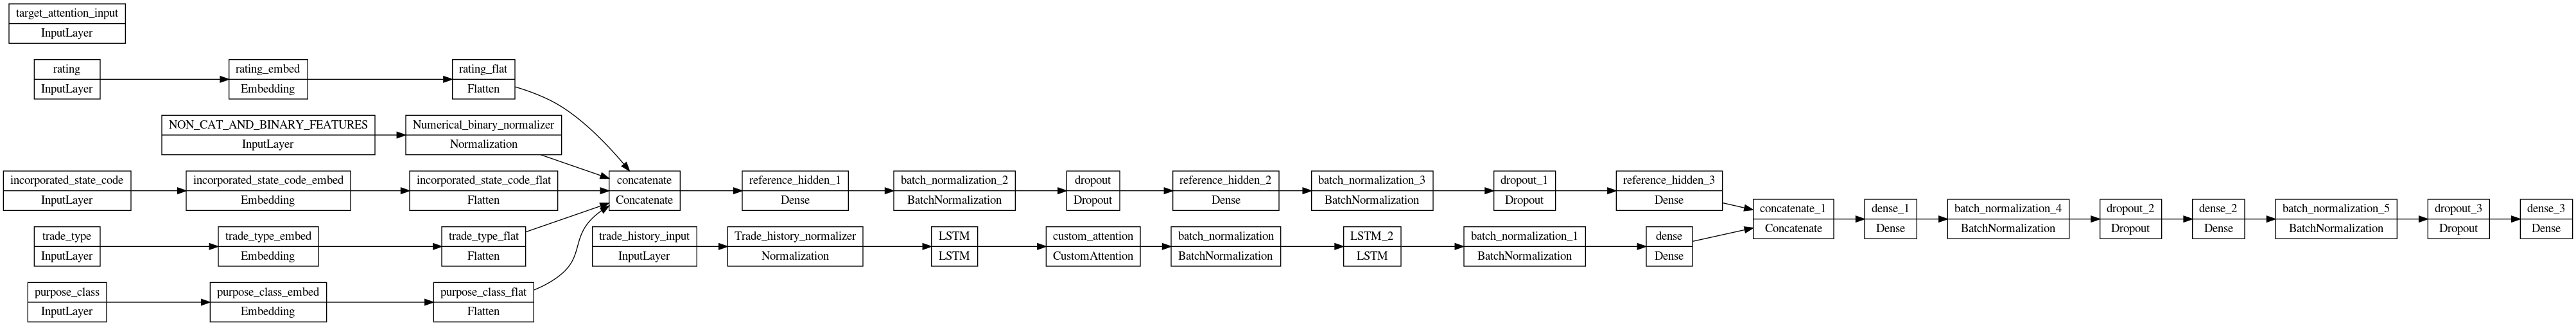

In [55]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [56]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [57]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [58]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [59]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100
7435/7435 [==============================] - 96s 12ms/step - loss: 28.6649 - mean_absolute_error: 28.6649 - val_loss: 13.5271 - val_mean_absolute_error: 13.5271
Epoch 2/100
7435/7435 [==============================] - 87s 12ms/step - loss: 11.1470 - mean_absolute_error: 11.1470 - val_loss: 12.7135 - val_mean_absolute_error: 12.7135
Epoch 3/100
7435/7435 [==============================] - 90s 12ms/step - loss: 10.7665 - mean_absolute_error: 10.7665 - val_loss: 12.8910 - val_mean_absolute_error: 12.8910
Epoch 4/100
7435/7435 [==============================] - 86s 12ms/step - loss: 10.5622 - mean_absolute_error: 10.5622 - val_loss: 12.5216 - val_mean_absolute_error: 12.5216
Epoch 5/100
7435/7435 [==============================] - 86s 12ms/step - loss: 10.4162 - mean_absolute_error: 10.4162 - val_loss: 12.3166 - val_mean_absolute_error: 12.3166
Epoch 6/100
7435/7435 [==============================] - 87s 12ms/step - loss: 10.3008 - mean_absolute_error: 10.3008 - val_loss: 12.12

KeyboardInterrupt: 

#### Plotting train vs validation loss

In [60]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

NameError: name 'history' is not defined

In [10]:
data.rating.value_counts()

AA      1612204
MR      1489748
AAA     1300254
AA+     1282871
AA-     1254224
A+       730202
A        482945
BBB+     252228
A-       242193
BBB       58138
NR        45309
BBB-      35590
BB+        8697
BB         7652
BB-        5152
B-         1501
B+          817
B           758
CC          304
CCC+        266
CCC-        137
CCC          70
D             5
Name: rating, dtype: int64

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'automated_training', f"encoders.pkl")

# print("Saving and uploading model")
# model.save(f"saved_model_test_{file_timestamp}")
# import shutil
# shutil.make_archive(f"model_march_20", 'zip', f"saved_model_test_{file_timestamp}")
# upload_data(storage_client, 'ahmad_data', f"model_march_20.zip")

file time stamp : 2023-03-21-00-37
Saving encoders and uploading encoders
File encoders.pkl uploaded to automated_training.


#### Gigaflops for one epoch of training

In [69]:
avg_time = np.mean(time_callback.times)

In [70]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

199.27141706915455


### Test accuracy on the entire test set

In [71]:
test_dataframe['predicted_ys'] = model.predict(x_test, batch_size=BATCH_SIZE)
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

In [72]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

Test loss: 9.53


In [73]:
print(f"YTW loss: {round(np.mean(np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)), 3)}")

YTW loss: 9.53


### Accuracy on a daily basis

Measuring the daily accuracy for large dealer dealer trades

In [74]:
for d in [d for d in pd.date_range(start="01/01/2023",end="01/31/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d) & 
                              (test_dataframe.trade_type == 'D') &
                              (test_dataframe.quantity >= np.log10(500000))].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.new_ys - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [75]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]#& (test_dataframe.coupon == 5)]

In [76]:
# true_mid = true_mid[(true_mid.rating.isin(['AA+','AAA','AA','AA-','A+','A','A-','BBB']) ) & (true_mid.incorporated_state_code == 'WA')]
# true_mid = true_mid[(true_mid.rating.isin(['AAA']) ) & (true_mid.incorporated_state_code == 'TX')]

In [77]:
len(true_mid)

5052

In [78]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.new_ys

CPU times: user 22.5 ms, sys: 33 µs, total: 22.5 ms
Wall time: 21.9 ms


In [79]:
%%time
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

6/6 [==============================] - 0s 5ms/step - loss: 6.8436 - mean_absolute_error: 6.8436
Test MAE: 6.844
CPU times: user 130 ms, sys: 5.82 ms, total: 136 ms
Wall time: 103 ms


### Plotting new ys vs predicted ys

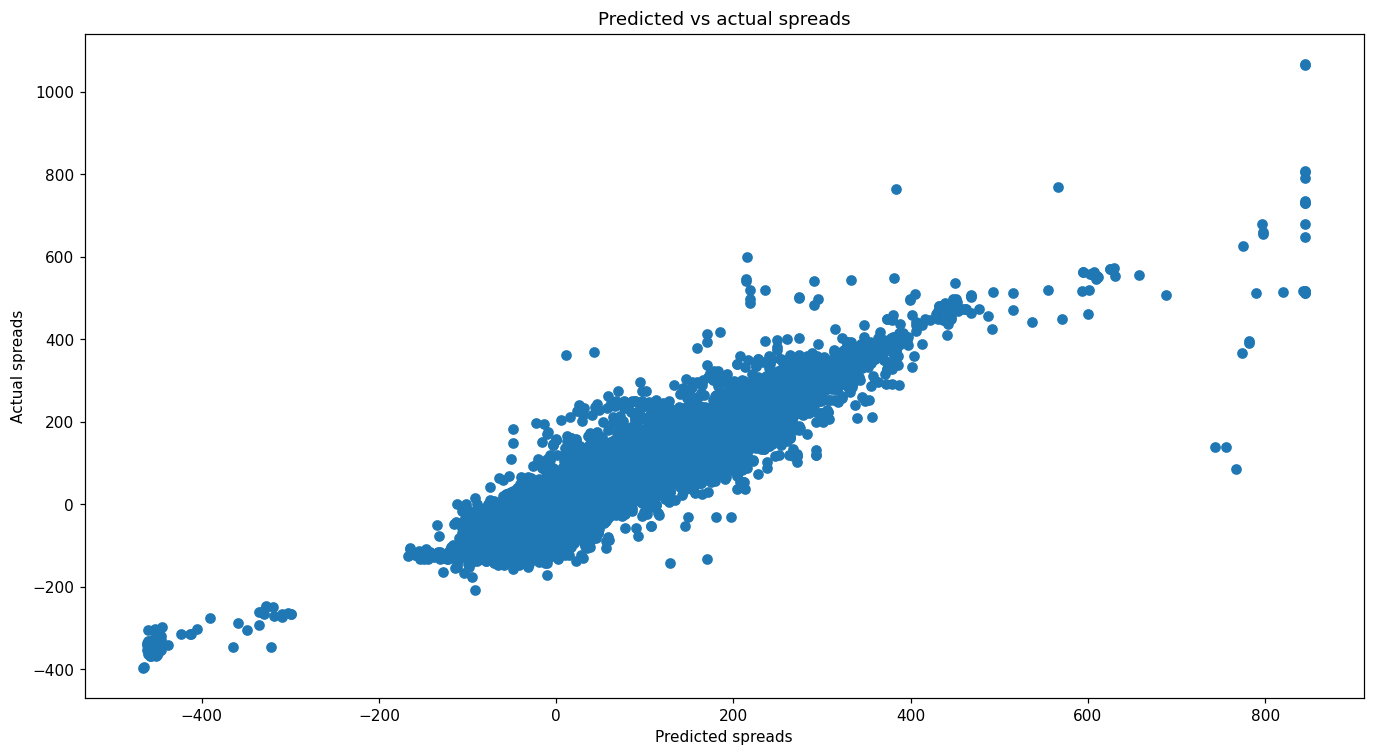

In [80]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted spreads')
plt.ylabel('Actual spreads')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_ys, test_dataframe.new_ys)

### Baseline using the last yield spread

In [81]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

16.845974789693464


### Baseline using the last yield spread on dealer dealer true mid trades

In [82]:
dd_dataframe = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
dd_last_ys_preds = dd_dataframe.last_yield_spread
error = dd_dataframe.yield_spread - last_ys_preds


MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(dd_last_ys_preds , dd_dataframe.yield_spread, dd_dataframe)

12.811945450750034


### Regression baseline using previous yield spread optimizing MAE

In [83]:
from statsmodels.regression.quantile_regression import QuantReg

In [84]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [85]:
res = q_reg.fit(q=.5)

In [86]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yield_spread = test_dataframe.yield_spread.values

In [87]:
MAE = np.mean(np.abs(actual_yield_spread - predicted_yield_spread))
print(MAE)

16.80402398217881


In [88]:
print(f'Regression coefficient {res.params[0]}')

Regression coefficient 0.9942665820938318


In [89]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()

In [90]:
y_mae_regression = res.params[0] * x_range

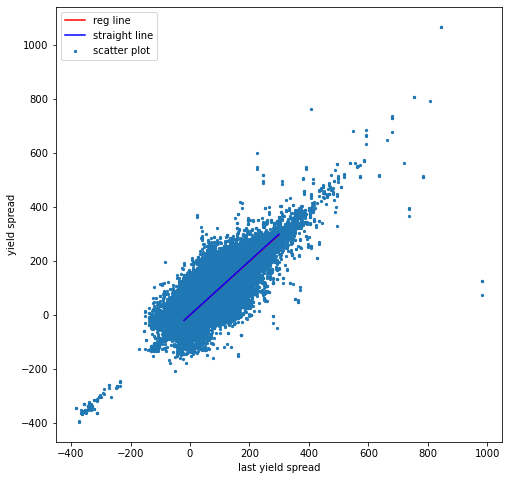

In [91]:
plt.figure(figsize=(8,8))
plt.scatter(test_dataframe.last_yield_spread, actual_yield_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()